In [1]:
import torch
import numpy as np
import uncertainty_toolbox as uct
import uncertainty_toolbox.metrics as umetrics
from uncertainty_toolbox.metrics_calibration import (
    get_proportion_lists_vectorized,
)
import uncertainty_toolbox.viz as uviz
from uncertainty_toolbox.recalibration import iso_recal

from data import data_preprocess
from evaluation import metrics
from model import concrete_dropout, deep_ensemble, subnetwork

In [2]:
x_train, y_train, x_test, y_test = data_preprocess.data_preprocess('mpg')

In [3]:
deep_ensemble_model = deep_ensemble.train_model(x_train, y_train)
concrete_dropout_model = concrete_dropout.train_model(x_train, y_train)

initial loss:  754.79638671875
final loss:  2.3162684440612793
initial loss:  953.2835693359375
final loss:  2.398179531097412
initial loss:  842.57080078125
final loss:  2.431083917617798
initial loss:  823.6951904296875
final loss:  2.375472068786621
initial loss:  926.1755981445312
final loss:  2.3201704025268555
final loss:  2.7869315147399902


Deep ensemble test MAPE:  0.078635596
Deep ensemble test RMSE:  2.5787187
Deep ensemble test NLLK:  2.5863495
Deep ensemble test CRPS:  tensor(1.3157)


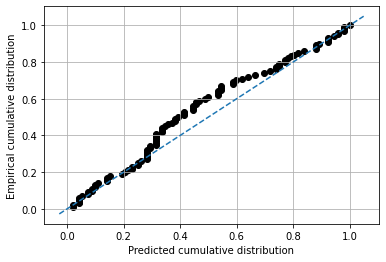

Deep ensemble test calibration error when step size is 0.001:  4.045480151228734
Deep ensemble test calibration error when step size is 0.01:  0.40450850661625726
Deep ensemble test calibration error when step size is 0.1:  0.043123818525519865


In [4]:
mean_pred, var_pred = deep_ensemble_model(x_test)
mean_pred = mean_pred.detach().numpy()
var_pred = var_pred.detach().numpy()
sd_pred = np.sqrt(var_pred)

print('Deep ensemble test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
print('Deep ensemble test RMSE: ', metrics.rmse(y_test.detach().numpy(), mean_pred))
print('Deep ensemble test NLLK: ', metrics.nllk(y_test.detach().numpy(), mean_pred, var_pred))
print('Deep ensemble test CRPS: ', metrics.CRPSMetric(x = y_test.squeeze(dim = 1), loc = torch.tensor(mean_pred).squeeze(dim = 1), scale = torch.tensor(sd_pred).squeeze(dim = 1)).gaussian_crps().mean())

pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
metrics.draw_pcdf(pcdf)
print('Deep ensemble test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('Deep ensemble test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('Deep ensemble test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))

In [5]:
print(uct.metrics.get_all_metrics(mean_pred.squeeze(1), sd_pred.squeeze(1), y_test.detach().numpy().squeeze(1)))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics


 20%|████████▌                                  | 2/10 [00:00<00:00, 10.39it/s]

 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


 20%|████████▌                                  | 2/10 [00:00<00:00, 11.68it/s]

  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 11.22it/s]

 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           1.848
  RMSE          2.579
  MDAE          1.429
  MARPD         7.840
  R2            0.883
  Correlation   0.940
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.040
  Mean-absolute Calibration Error       0.031
  Miscalibration Area                   0.032
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.160
     Group Size: 0.56 -- Calibration Error: 0.062
     Group Size: 1.00 -- Calibration Error: 0.031
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.199
     Group Size: 0.56 -- Calibration Error: 0.085
     Group Size: 1.00 -- Calibration Error: 0.040
================

Lims is None. Setting lims now:
min_max_true: (11.0, 46.6)
min_max_pred: (12.378082, 44.76595)
lims: (11.0, 46.6)
lims_ext: (7.44000015258789, 50.1599983215332)


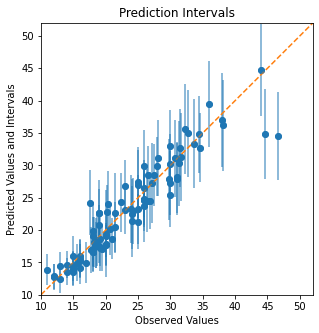

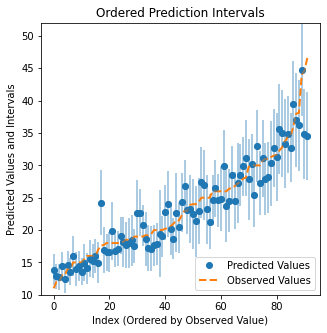

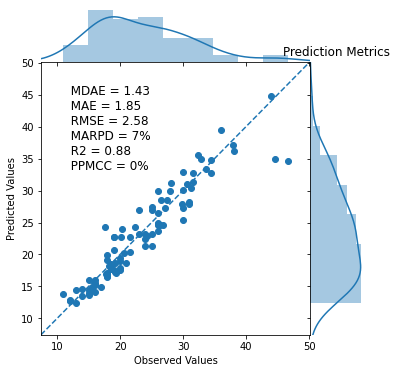

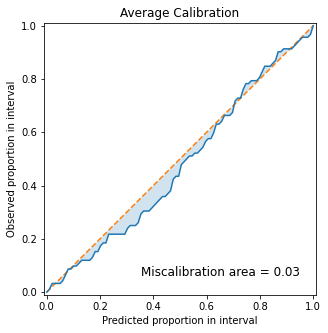

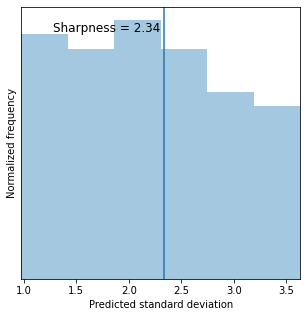

In [6]:
y = y_test.detach().numpy().squeeze(1)

uviz.plot_intervals(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_intervals_ordered(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_parity(mean_pred.squeeze(1), y)
uviz.plot_calibration(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_sharpness(sd_pred.squeeze(1))

Concrete dropout test MAPE:  0.098220766
Concrete dropout test RMSE:  2.946654
Concrete dropout test NLLK:  2.995222
Concrete dropout test CRPS:  tensor(1.6064)


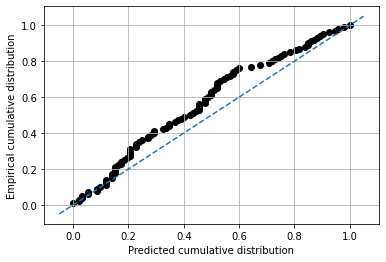

Concrete dropout test calibration error when step size is 0.001:  7.805159735349719
Concrete dropout test calibration error when step size is 0.01:  0.7824952741020798
Concrete dropout test calibration error when step size is 0.1:  0.07450378071833652


In [7]:
mean_pred, log_var_pred, _ = concrete_dropout_model(x_test)
mean_pred = mean_pred.detach().numpy()
var_pred = np.exp(log_var_pred.detach().numpy())
sd_pred = np.sqrt(var_pred)

print('Concrete dropout test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
print('Concrete dropout test RMSE: ', metrics.rmse(y_test.detach().numpy(), mean_pred))
print('Concrete dropout test NLLK: ', metrics.nllk(y_test.detach().numpy(), mean_pred, var_pred))
print('Concrete dropout test CRPS: ', metrics.CRPSMetric(x = y_test.squeeze(dim = 1), loc = torch.tensor(mean_pred).squeeze(dim = 1), scale = torch.tensor(sd_pred).squeeze(dim = 1)).gaussian_crps().mean())

pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
metrics.draw_pcdf(pcdf)
print('Concrete dropout test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('Concrete dropout test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('Concrete dropout test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))

In [8]:
print(uct.metrics.get_all_metrics(mean_pred.squeeze(1), sd_pred.squeeze(1), y_test.detach().numpy().squeeze(1)))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics


 20%|████████▌                                  | 2/10 [00:00<00:00, 11.40it/s]

 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


 20%|████████▌                                  | 2/10 [00:00<00:00, 10.57it/s]

  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 10.76it/s]

 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           2.259
  RMSE          2.947
  MDAE          1.693
  MARPD         9.944
  R2            0.847
  Correlation   0.927
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.046
  Mean-absolute Calibration Error       0.038
  Miscalibration Area                   0.038
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.171
     Group Size: 0.56 -- Calibration Error: 0.084
     Group Size: 1.00 -- Calibration Error: 0.038
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.211
     Group Size: 0.56 -- Calibration Error: 0.100
     Group Size: 1.00 -- Calibration Error: 0.046
================

Lims is None. Setting lims now:
min_max_true: (11.0, 46.6)
min_max_pred: (11.140369, 46.398483)
lims: (11.0, 46.6)
lims_ext: (7.44000015258789, 50.1599983215332)


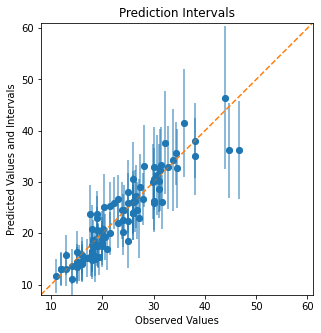

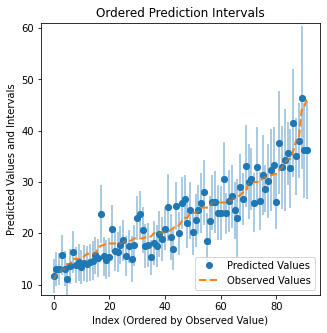

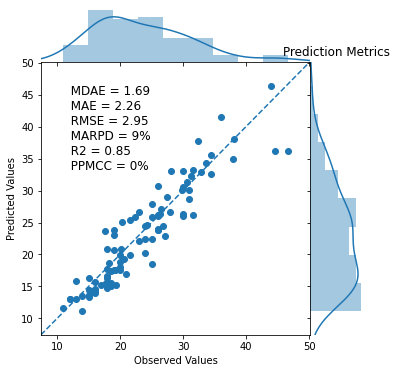

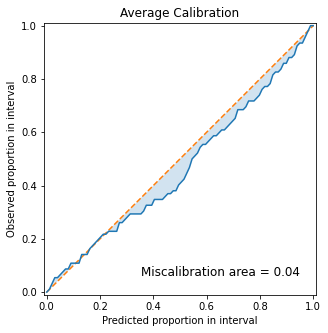

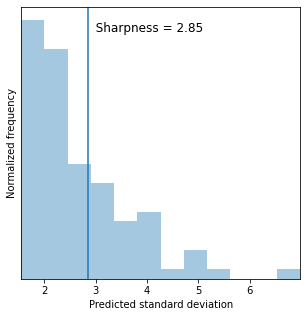

In [9]:
y = y_test.detach().numpy().squeeze(1)

uviz.plot_intervals(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_intervals_ordered(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_parity(mean_pred.squeeze(1), y)
uviz.plot_calibration(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_sharpness(sd_pred.squeeze(1))

In [15]:
subnetwork_model = subnetwork.train_model(x_train, y_train, learning_rate = .007)

initial loss:  925.289306640625
final loss:  3.0745482444763184


Subnetwork test MAPE:  0.09322781
Subnetwork test RMSE:  2.7978017
Subnetwork test NLLK:  2.9860885
Subnetwork test CRPS:  tensor(1.5351)


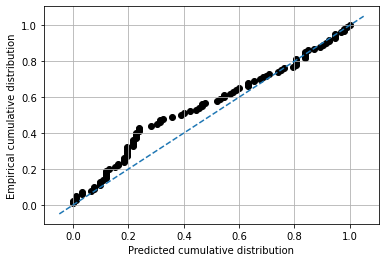

Subnetwork test calibration error when step size is 0.001:  6.0911578449905495
Subnetwork test calibration error when step size is 0.01:  0.6154300567107753
Subnetwork test calibration error when step size is 0.1:  0.06167296786389417


In [19]:
mean_pred, var_pred = subnetwork.test_model(subnetwork_model, x_test)
mean_pred = mean_pred.detach().numpy()
var_pred = var_pred.detach().numpy()
sd_pred = np.sqrt(var_pred)

print('Subnetwork test MAPE: ', metrics.mape(y_test.detach().numpy(), mean_pred))
print('Subnetwork test RMSE: ', metrics.rmse(y_test.detach().numpy(), mean_pred))
print('Subnetwork test NLLK: ', metrics.nllk(y_test.detach().numpy(), mean_pred, var_pred))
print('Subnetwork test CRPS: ', metrics.CRPSMetric(x = y_test.squeeze(dim = 1), loc = torch.tensor(mean_pred).squeeze(dim = 1), scale = torch.tensor(sd_pred).squeeze(dim = 1)).gaussian_crps().mean())

pcdf = metrics.pcdf(mean_pred.squeeze(1), var_pred.squeeze(1), y_test.detach().numpy().squeeze(1))
metrics.draw_pcdf(pcdf)
print('Subnetwork test calibration error when step size is 0.001: ', metrics.calibration_error(pcdf, step = 0.001))
print('Subnetwork test calibration error when step size is 0.01: ', metrics.calibration_error(pcdf, step = 0.01))
print('Subnetwork test calibration error when step size is 0.1: ', metrics.calibration_error(pcdf, step = 0.1))

In [20]:
print(uct.metrics.get_all_metrics(mean_pred.squeeze(1), sd_pred.squeeze(1), y_test.detach().numpy().squeeze(1)))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics


 20%|████████▌                                  | 2/10 [00:00<00:00, 11.12it/s]

 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


 20%|████████▌                                  | 2/10 [00:00<00:00, 10.93it/s]

  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 10.72it/s]

 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           2.070
  RMSE          2.798
  MDAE          1.606
  MARPD         9.370
  R2            0.862
  Correlation   0.934
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.065
  Mean-absolute Calibration Error       0.057
  Miscalibration Area                   0.058
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.213
     Group Size: 0.56 -- Calibration Error: 0.100
     Group Size: 1.00 -- Calibration Error: 0.057
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.225
     Group Size: 0.56 -- Calibration Error: 0.106
     Group Size: 1.00 -- Calibration Error: 0.065
================

Lims is None. Setting lims now:
min_max_true: (11.0, 46.6)
min_max_pred: (10.853513, 39.218502)
lims: (10.853513, 46.6)
lims_ext: (7.278864097595214, 50.17464714050293)


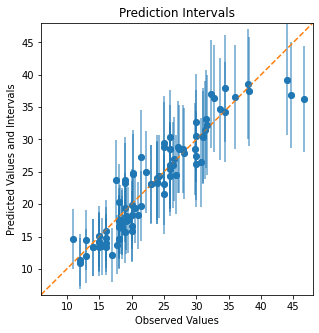

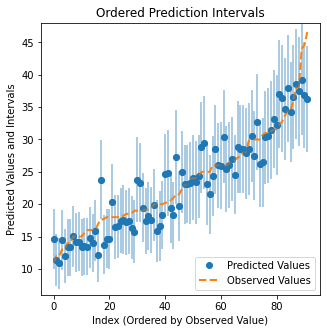

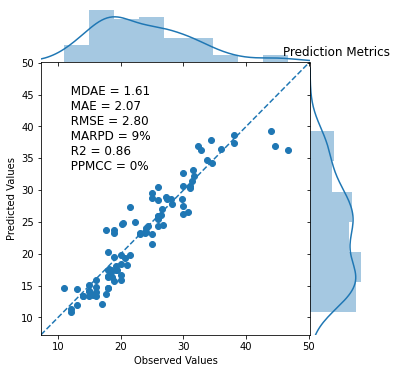

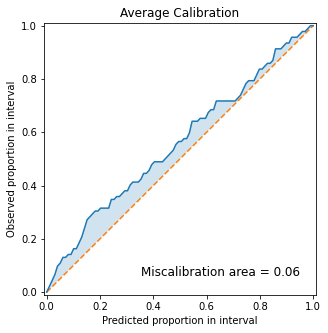

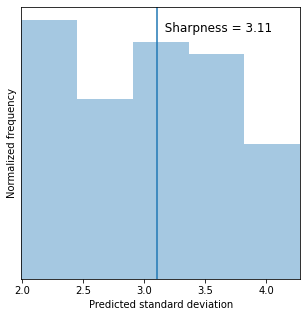

In [21]:
y = y_test.detach().numpy().squeeze(1)

uviz.plot_intervals(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_intervals_ordered(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_parity(mean_pred.squeeze(1), y)
uviz.plot_calibration(mean_pred.squeeze(1), sd_pred.squeeze(1), y)
uviz.plot_sharpness(sd_pred.squeeze(1))